# Devoir Topas - Équipe électron
## PHY-7051 Physique des radiations en radiothérapie et en radiologie

Frédérique Larose (111 238 325), Élodie Moth (), Isaac Gomez (111 274 808), Zahra Khazaei (537 116 217)



### Packages utilisés

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from matplotlib.patches import Rectangle
from scipy.stats import linregress
from scipy.interpolate import make_interp_spline
import seaborn as sns


### Fonctions et constantes

In [21]:
# Fonction servant à convertir les fichiers de simulations csv en numpy (même fonction que l'année précédente).

def csv_to_np(name, skip_num=8, start_col=2):
    """Fonction pour transformer les fichiers csv en numpy array 2d.
    Par défaut, seul les 3 dernières colonnes sont conservées (numéro du bin, dose (Gy), écart-type (Gy)).
    name: nom en string du fichier csv.
    skip_num: nombre de rangées au début du fichier à passer (dans l'header). Par défaut = 8.
    start_col: numéro de la première colonne à conserver, par défaut = 2 pour conserver les 3 dernières seulement.
    """
    
    #data = pd.read_csv("/Users/frederiquelarose/Desktop/Cours_Automne_2023/Physique_des_radiations/Devoir_Topas/Resultats_6.9/"+name,sep=',', header=None, skiprows=skip_num).to_numpy()[:,start_col:]
    data = pd.read_csv("Résultats/"+name,sep=',', header=None, skiprows=skip_num).to_numpy()[:,start_col:]
    return data



# Constantes

MeV_to_joule = 1.602176565e-13 # J/MeV
rho_eau = 0.9982 # g/cm3
Rcsda = np.array([4.367e-1, 0.9783, 2.35, 4.975, 9.32, 13.17, 16.65, 19.83])




# 1. Figure 6.6 : Distribution de la dose en profondeur dans l'eau

1 MeV - Erreur relative suffisante atteinte!
0.0292 % < 3 %
2 MeV - Erreur relative suffisante atteinte!
0.0132 % < 3 %
5 MeV - Erreur relative suffisante atteinte!
0.018 % < 3 %
10 MeV - Erreur relative suffisante atteinte!
0.00914 % < 3 %
20 MeV - Erreur relative suffisante atteinte!
0.00674 % < 3 %
30 MeV - Erreur relative suffisante atteinte!
0.00302 % < 3 %
40 MeV - Erreur relative suffisante atteinte!
0.00357 % < 3 %
50 MeV - Erreur relative suffisante atteinte!
0.00238 % < 3 %


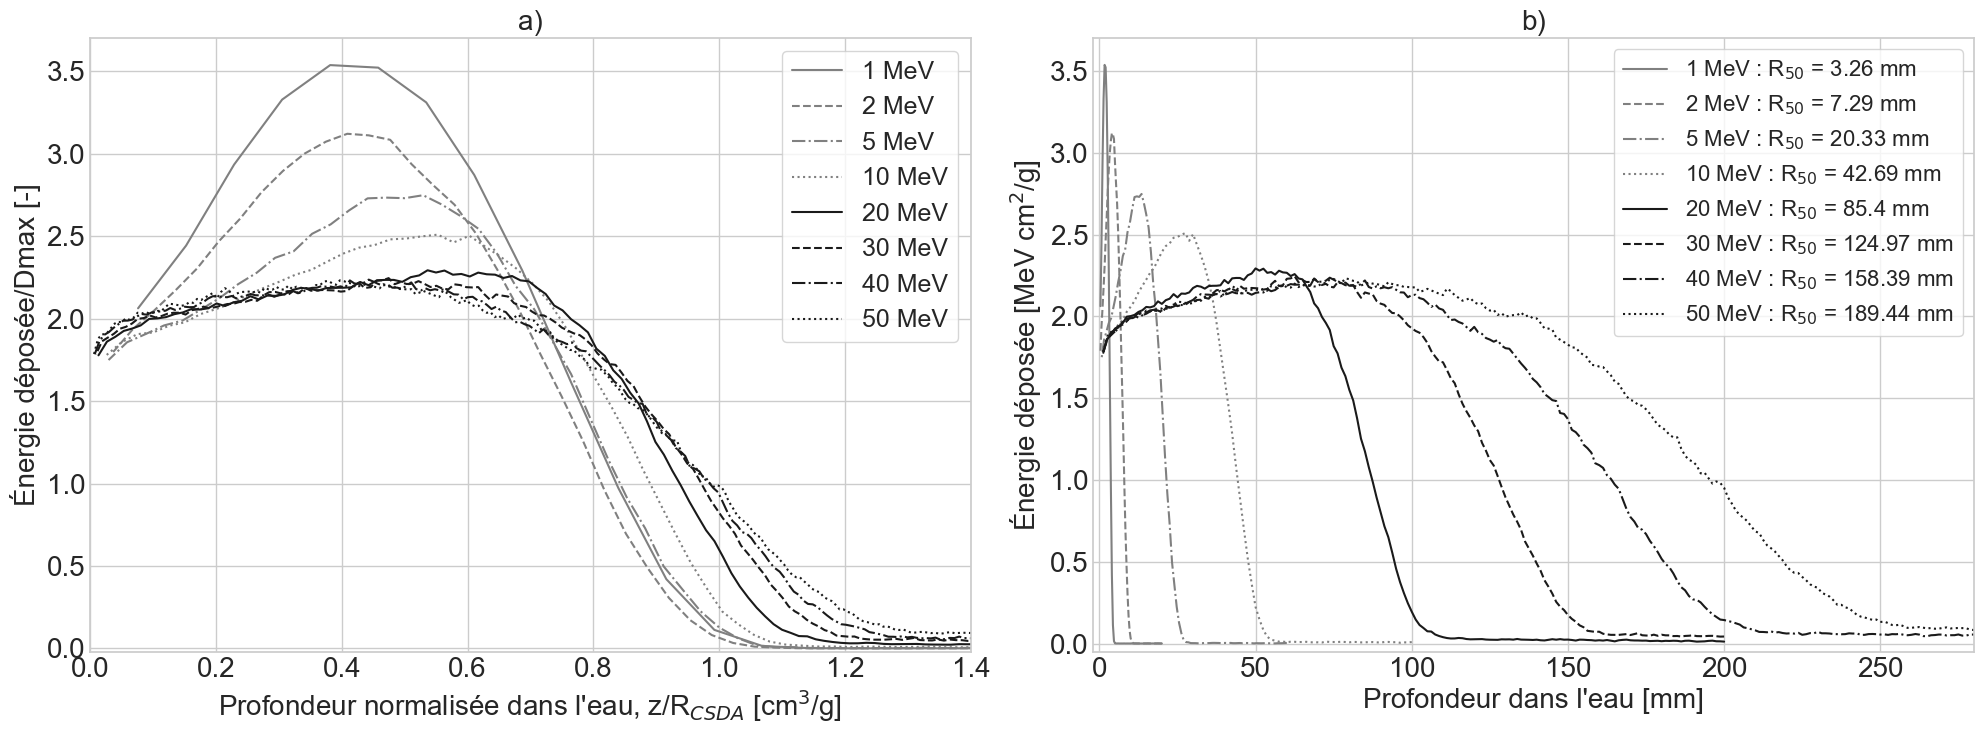

Les rapports de la dose à la surface sur la dose maximale pour 1, 2, 5, 10, 20, 30, 40 et 50 MeV sont respectivement: [58.3  57.22 63.63 70.76 77.51 79.41 79.78 79.94] %


In [22]:
""" Le code ci-bas génère la figure 6.6 du manuel de référence, soit la superposition des courbes
    de distribution de dose pour des faisceaus d'électrons de différente énergie (1-50 MeV) dans un fantôme d'eau."""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. 
Les portés Rcsda ne sont pas utilisées directement dans les codes TOPAS, mais le paramètre
HLZ du scorer est réglé pour que sa profondeur totale soit plus grande que la portée Rcsda en cm."""

field_size = 100 # cm2
energies = np.array([1, 2, 5, 10, 20, 30, 40, 50])
Rcsda = np.array([4.367e-1, 0.9783, 2.55, 4.975, 9.32, 13.17, 16.65, 19.83]) # g/cm2
Rcsda_cm = Rcsda/rho_eau # cm
el_nbr = np.array([2000000, 2000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000]) # nbr d'électrons simulés pour chaque énergie
bin_nbr = np.array([60, 60, 80, 80, 160, 160, 240, 240]) # nbr de bins pour chaque énergie
tot_depths = np.array([2, 2, 6, 10, 20, 20, 30, 30]) # profondeur des scorers pour chaque énergie, cm
in_fluence = el_nbr/field_size # cm-2

np.seterr(divide='ignore', invalid='ignore')

# initialisation des matrices de données
data=np.empty((np.size(energies),np.max(bin_nbr),3))
std_rel = np.empty(np.size(energies))
R50 = np.empty(np.size(energies))
Dmax = np.empty(np.size(energies))
Dsurf = np.empty(np.size(energies))


# initialisation des figures

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7.5))  

ax1.set_xlabel("Profondeur normalisée dans l'eau, z/R$_{CSDA}$ [cm$^3$/g]", fontsize='20')
ax1.set_ylabel("Énergie déposée/Dmax [-]", fontsize='20')
ax1.set_title("a)", fontsize='20')
ax1.tick_params(direction='in', labelsize='20')

ax2.set_xlabel("Profondeur dans l'eau [mm]", fontsize='20')
ax2.set_ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='20')
ax2.set_title("b)", fontsize='20')
ax2.tick_params(direction='in', labelsize='20')

marker = ['-','--','-.',':','k-','k--','k-.','k:']

# ------------------------------- Fonctions de calcul ------------------------------------------- #
for i in range(len(energies)):
    e = np.array2string(energies[i])
    name = '6.6_{}MeV.csv'.format(e)
    data[i][:bin_nbr[i],:] = csv_to_np(name) # extraction des données csv en numpy array
    bins = data[i][:bin_nbr[i],0]
    dose = data[i][:bin_nbr[i],1]
    std = data[i][:bin_nbr[i],2]

    # vecteurs de profondeur
    depth = (bin_nbr[i]-bins)*(tot_depths[i]/bin_nbr[i]) # cm, défini à partir des numéros de bins et de la profondeur totale du scorer
    depth_norm = depth/Rcsda[i] # cm

    # erreur relative
    std_rel[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel[i] < 3: # erreur maximale est choisie à 3%
        print(energies[i], "MeV - Erreur relative suffisante atteinte!")
        print(format(std_rel[i], '.3g'), "% <", "3 %")
    else:
        print(energies[i], "MeV - Erreur relative trop élevée")
        print(format(std_rel[i], '.3g'), "% >", "3 %")

    # conversion dose
    dose_norm = dose/(1000*MeV_to_joule*in_fluence[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Dmax
    """ Calcul de Dmax à l'aide d'une inteprolation sur la courbe de dose soustraite par la dose maximale"""
    dose_max = np.max(dose_norm)
    freduced1 = interpolate.UnivariateSpline(np.flip(depth*10), np.flip((dose_norm-dose_max)), s=0)
    Dmax[i] = np.mean(freduced1.roots())

    # R50
    """ Calcul de R50 à l'aide d'une inteprolation sur la courbe de dose soustraite par la dose à 50%"""
    dose_50 = 0.5*dose_max
    freduced2 = interpolate.UnivariateSpline(np.flip(depth*10), np.flip((dose_norm-dose_50)), s=0)
    R50[i] = freduced2.roots()

    # Dose à la surface
    """ Calcul du rapport de la dose à la surface sur la dose maximale"""
    Dsurf[i] = 100*dose_norm[-1]/dose_max

    if energies[i] < 11:
        # figure 6.6a)
        ax1.plot(depth_norm, dose_norm, marker[i], label = "{} MeV".format(e), color="grey")
        # figure 6.6b)
        ax2.plot(depth*10, dose_norm, marker[i], label = "{} MeV : R$_{{50}}$ = {} mm".format(e,round(R50[i],2)), color="grey")
    else:
        # figure 6.6a)
        ax1.plot(depth_norm, dose_norm, marker[i], label = "{} MeV".format(e))
        # figure 6.6b)
        ax2.plot(depth*10, dose_norm, marker[i], label = "{} MeV : R$_{{50}}$ = {} mm".format(e,round(R50[i],2)))

ax1.set_xlim([0, 1.4])
ax1.set_ylim([-0.02, 3.7])
ax2.set_xlim([-2, 280])
ax2.set_ylim([-0.05, 3.7])
ax1.legend(loc=0, frameon=True, fontsize='18')
ax2.legend(loc=0, frameon=True, fontsize='16')
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

print("Les rapports de la dose à la surface sur la dose maximale pour 1, 2, 5, 10, 20, 30, 40 et 50 MeV sont respectivement:",np.round(Dsurf,2),"%")




**Figure 1** - Distribution de l'énergie en fonction de la profondeur le long de l'axe central, causée par des faisceaux parallèles d'électrons monoénergétiques ayant une énergie comprise entre 1 et 50 MeV dans un milieu d'eau. Pour la figure a), la profondeur est normalisée en fonction de la portée CSDA des électrons.

## Discussion figure 6.6

De ces deux figures, plusieurs points peuvent être soulevés:

**Différence à 1Mev:** La dose maximale que l'on observe pour le faisceau d'électrons de 1 MeV ne correspond pas exactement à la valeur théoriquement anticipée, à cause de la configuration spécifique du faisceau. En effet, dans cette configuration, la géométrie "broad beam " (faisceau large) n'est pas parfaitement respectée, du fait que les électrons sont dispersés dans toutes les directions.

**Region de build up :** La montée vers la dose maximale varie en fonction de l'énergie. Pour les basses énergies, cette region est plus prononcée car les électrons subissent de nombreuses difussions élastiques qui déposent l'énergie sur une plus petite région, créant ainsi une montée rapide et prononcée de la dose. En ce qui concerne les hautes énergies, la montée est moins prononcée en raison de la diffusion vers l'avant. 

**Diminution de la dose après Dmax:** La dose chute rapidement après avoir atteint $D_{max}$ parce que les électrons ont perdu la majorité de leur énergie par des diffusions élastiques et inélastiques. Cette chute est plus marquée pour les électrons de basse énergie, qui sont diffusés à plus grands angles et donc perdent de l'énergie plus rapidement.

**Queue bremsstrahlung:** Aux profondeurs supérieures à $R_{CSDA}$, il reste une dose détectable due aux interactions bremsstrahlung. Cette contribution est plus significative à des énergies élevées car le pouvoir d'arrêt radiatif augmente avec l'énergie de l'électron.

**Dose à la surface:** Les électrons de plus faible énergie sont diffusés plus largement, ce qui augmente la dose à la surface pour les énergies plus basses. Cependant, avec des énergies plus élevées, les électrons pénètrent plus dans le milieu avant de déposer une grande partie de leur énergie. 


## Étude du nombre d'histoire pour la même énergie

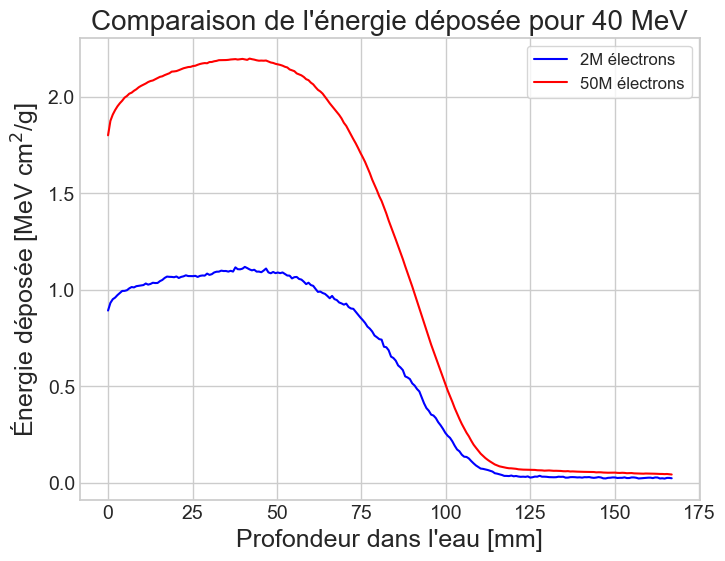

In [23]:

# Function to read CSV and convert to NumPy array
def csv_to_np2(directory, name, electron_number, skip_num=8, start_col=2):
    field_size = 100 # cm2
    fluence = electron_number / field_size # cm-2
    MeV_to_joule = 1.602176565e-13 # J/MeV
    rho_eau = 0.9982 # g/cm3
    Rcsda = 16.65 # g/cm2
    Rcsda_cm = Rcsda / rho_eau # cm

    data = pd.read_csv(f"{directory}/{name}", sep=',', header=None, skiprows=skip_num).to_numpy()[:, start_col:]
    bins = data[:, 0]
    dose = data[:, 1]
    # Convert dose to MeV cm^2/g
    dose_norm = dose / (1000 * MeV_to_joule * fluence)
    depth = (np.max(bins) - bins) * (Rcsda_cm / np.max(bins)) # cm
    #depth = np.array()

    return depth, dose_norm


# Function to plot energy deposition
def plot_energy_deposition(directory, electron_number, color, label):
    depth, dose_norm = csv_to_np2(directory, '6.6_40_{}MeV.csv'.format(electron_number), electron_number)
    plt.plot(depth * 10, dose_norm, label=label, color=color)

# Initialize the plot
plt.figure(figsize=(8, 6))

# Plot for the 'Résultats' directory
plot_energy_deposition('Résultats', 2000000, 'blue', '2M électrons')

# Plot for the 'Résultats1' directory
plot_energy_deposition('Résultats', 50000000, 'red', '50M électrons')

# Customize and display the plot
plt.xlabel("Profondeur dans l'eau [mm]", fontsize=18)
plt.ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize=18)
plt.title("Comparaison de l'énergie déposée pour 40 MeV", fontsize=20)
plt.legend(loc='best', frameon=True, fontsize=12)
plt.tick_params(direction='in', labelsize=14)
plt.grid(True)
plt.show()


## Étude de la relation entre R50 et Dmax selon l'énergie du faisceau

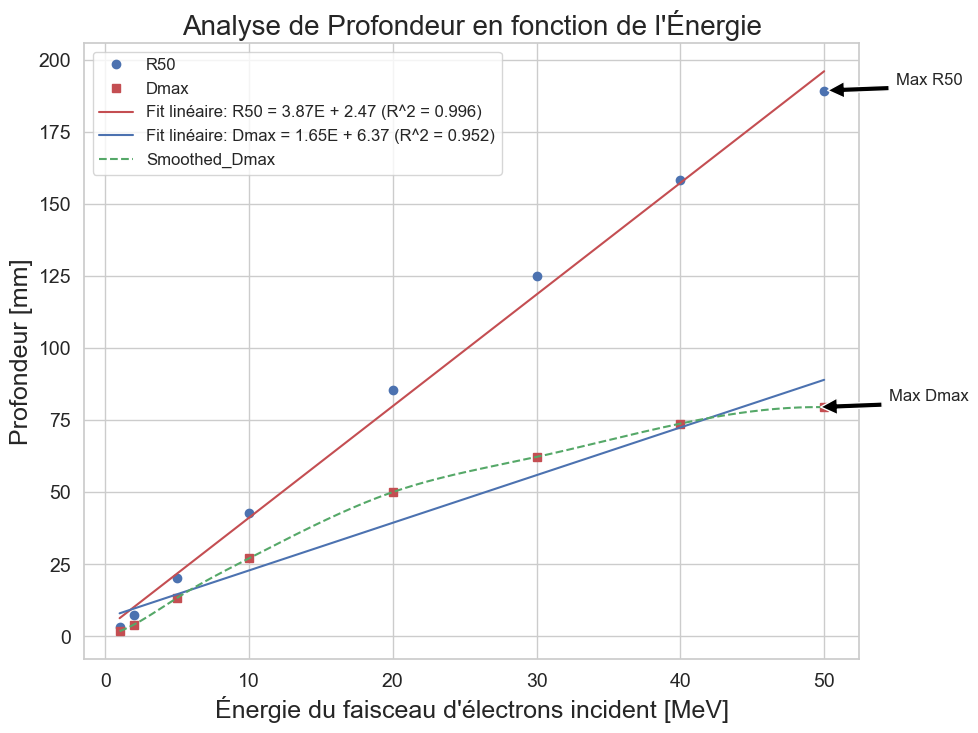

In [26]:

# Set the seaborn style for better aesthetics
sns.set(style="whitegrid")

# Compute linear fits
fit_dmax = linregress(energies, Dmax)
fit_R50 = linregress(energies, R50)

# Generate the x-values for plotting the fit lines
x_dmax = np.linspace(1, 50, 100)
y_dmax = fit_dmax.slope * x_dmax + fit_dmax.intercept

x_R50 = np.linspace(1, 50, 100)
y_R50 = fit_R50.slope * x_R50 + fit_R50.intercept

# Create the figure and axis objects
fig2, ax1 = plt.subplots(figsize=(10, 8))

# Plot the actual data points
ax1.plot(energies, R50, 'bo', label="R50")  # Blue circles for R50
ax1.plot(energies, Dmax, 'rs', label="Dmax")  # Red squares for Dmax

# Use spline interpolation for Dmax
spline = make_interp_spline(energies, Dmax, k=3)
x_Dmax_smooth = np.linspace(min(energies), max(energies), 300)
y_Dmax_smooth = spline(x_Dmax_smooth)


# Plot the linear fit lines
ax1.plot(x_R50, y_R50, 'r-', label=f"Fit linéaire: R50 = {round(fit_R50.slope,2)}E + {round(fit_R50.intercept,2)} (R^2 = {round(fit_R50.rvalue**2,3)})")
ax1.plot(x_dmax, y_dmax, 'b-', label=f"Fit linéaire: Dmax = {round(fit_dmax.slope,2)}E + {round(fit_dmax.intercept,2)} (R^2 = {round(fit_dmax.rvalue**2,3)})")
ax1.plot(x_Dmax_smooth, y_Dmax_smooth, 'g--', label="Smoothed_Dmax")  
# Annotating points of maximum R50 and Dmax
max_R50 = np.max(R50)
max_Dmax = np.max(Dmax)
max_R50_energy = energies[np.argmax(R50)]
max_Dmax_energy = x_Dmax_smooth[np.argmax(y_Dmax_smooth)]

# Adding annotations with arrows
ax1.annotate('Max R50', xy=(max_R50_energy, max_R50), xytext=(max_R50_energy+5, max_R50+2),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)
ax1.annotate('Max Dmax', xy=(max_Dmax_energy, max_Dmax), xytext=(max_Dmax_energy+5, max_Dmax+2),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

# Setting the labels and title
ax1.set_xlabel("Énergie du faisceau d'électrons incident [MeV]", fontsize=18)
ax1.set_ylabel("Profondeur [mm]", fontsize=18)
ax1.set_title("Analyse de Profondeur en fonction de l'Énergie", fontsize=20)

# Customizing the tick parameters
ax1.tick_params(axis='both', which='major', labelsize=14)

# Adding the legend with a frame
ax1.legend(loc='upper left', frameon=True, fontsize=12)

plt.savefig("/Users/frederiquelarose/Desktop/image.jpg",dpi=300,bbox_inches="tight")
plt.show()




Sur cette figure, les profondeurs R50 et Dmax calculées à l'aide de simulations de Monte Carlo pour 2 millions de faisceaux d'électrons monoénergétiques parallèles d'énergies comprises entre 1 et 50 MeV. Des interpolations linéaires sont effectuées sur les données expérimentales, mais on peut constater que pour le chiffre Dmax, il ne semble pas s'agir d'un fit linéaire.

# 2.  Figure 6.9 : Influence d'une inhomogénéité sur une distribution dose en profondeur 

Air - Erreur relative suffisante atteinte!
0.000198 % < 3 %
Al - Erreur relative suffisante atteinte!
0.000633 % < 3 %
Eau - Erreur relative suffisante atteinte!
0.000184 % < 3 %
Pb - Erreur relative suffisante atteinte!
0.00111 % < 3 %


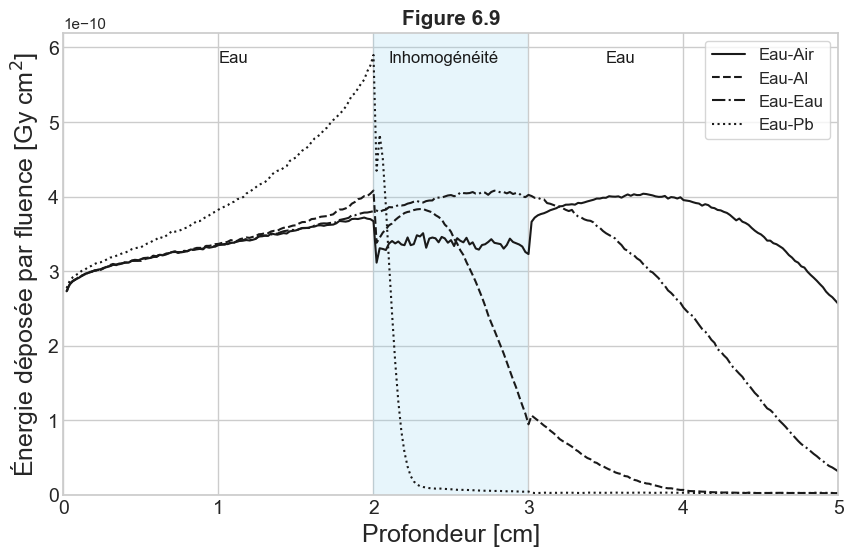

In [14]:
""" Le code ci-bas génère la figure 6.9 du manuel de référence, soit la superposition des courbesù
    de distribution de dose pour un faisceau d'électrons de 10MeV dans un fantôme d'eau contenant
    une inhomogénéité de 1cm de large de nature définie. La simulation est effectuée
    en utilisant 10^8 histoires."""

# ------------------------------- Paramètres ------------------------------------------- #
field_size = 100 # cm2
energy = 10 # MeV

el_nbr = 10000000 # nbr d'électrons simulés pour chaque inhomogénéité
bin_nbr = 250 # nbr de bins utilisé
materials = ["Air", "Al", "Eau", "Pb"] # inhomogénéités considérées
tot_depth = 5 # profondeur du scorer, cm
in_fluence = el_nbr/field_size # fluence simulée, cm-2

# initialisation des matrices de données
data=np.empty([np.size(materials),bin_nbr,3])
std_rel = np.empty(np.size(materials))

# initialisation des figures
fig1 = plt.figure(figsize=(10, 6))
ax1 = plt.subplot(1, 1, 1)
plt.xlabel("Profondeur [cm]", fontsize='18')
plt.ylabel("Énergie déposée par fluence [Gy cm$^2$]", fontsize='18')
plt.title("",  fontsize='20')

marker = ['k-','k--','k-.','k:']

# ------------------------------- Fonctions de calcul ------------------------------------------- #

for i in range(len(materials)):
    material = materials[i]
    name = 'Dose_{}_6-9.csv'.format(material)
    data[i][:bin_nbr,:] = csv_to_np(name)
    bins = data[i][:bin_nbr,0]
    dose = data[i][:bin_nbr,1]
    std = data[i][:bin_nbr,2]

    # vecteurs de profondeur
    depth = (bin_nbr - bins)*(tot_depth/bin_nbr) # cm

    # erreur relative
    std_rel[i] = (np.mean(std/dose))*100 # % erreur moyen sur mesure de dose

    if std_rel[i] < 3:
        print(material, "- Erreur relative suffisante atteinte!")
        print(format(std_rel[i], '.3g'), "% < 3 %")

    # dose normalisée selon la fluence
    dose_norm = (dose/in_fluence) # Gy cm2

    # figure 6.9
    ax1.plot(depth, dose_norm, marker[i], label = "Eau-{}".format(material))

# ------------------------------- Affichage final des résultats ------------------------------------------- #

ax1.set_xlim([0, 5])
ax1.set_ylim([0, 6.2e-10])
ax1.legend(loc=0, frameon=True, fontsize='12')
ax1.minorticks_on()

ax1.add_patch( Rectangle((2, -1e-10),
                        1, 8e-10,
                        fc ='skyblue',alpha = 0.2,
                        lw = 0) )
plt.annotate('Eau', (1, 5.8e-10), fontsize=12, color='k')
plt.annotate('Inhomogénéité', (2.1, 5.8e-10), fontsize=12, color='k')
plt.annotate('Eau', (3.5, 5.8e-10), fontsize=12, color='k')
plt.tick_params(which='both',direction='in',labelsize='14')
plt.title('Figure 6.9', fontsize = 15, weight = 'semibold')
plt.show()



**Figure 3** - Dose selon la profondeur dans l'eau d'un faisceau d'électrons monoénergétique parallèle de 10 MeV, lors de la présence d'une inhomogénéité de 1 cm d'air, d'aluminium (Al) ou de plomb (Pb).






Le graphique obtenu pour l’influence d’une inhomogénéité dans le milieu d’eau représente bien la figure 6.9 du manuel. Les simulations ont été effectuées pour 10 000 000 de particules, ce qui permet amplement d’atteindre une erreur relative satisfaisante de moins de 3%. On remarque d’abord une augmentation de la dose avant l’interface d’inhomogénéité pour les matériaux à grand Z. Cette augmentation avant le milieu est due aux électrons rétrodiffusés ou back-scattered électrons résultant de l’impact du faisceau primaire avec le milieu. Ensuite, on observe que lorsque le milieu a un Z plus grand que celui de l’eau, la courbe dans l’inhomogénéité devient plus étroite. Ce phénomène s’explique par la différence entre les pouvoirs d’arrêt des différents matériaux. L’aluminium et le plomb, par exemple, réagissent de la même façon, mais l’effet est beaucoup plus marqué pour le plomb en raison de son plus grand Z. L’air, au contraire, ayant une masse volumique plus petite que l’eau, on observe l’effet inverse de celui du plomb et de l’aluminium. La dose reste plutôt constante dans l’air en raison de son faible pouvoir d’arrêt. Il pourrait être intéressant de répéter l’expérience à différentes énergies ou encore à différentes épaisseurs d'inhomogénéité afin d’étudier comment la dose réagit dans ces conditions !

# 3. Spectre en énergie des électrons primaires et secondaires

In [15]:
file1 = 'Résultats/Fluence_primaire.csv' 
file2 = 'Résultats/Fluence_Secondaire.csv'

data1 = np.loadtxt(file1, delimiter=',', skiprows=12)
data2 = np.loadtxt(file2, delimiter=',', skiprows=12)

#La longeur du scorer est 80mm
#Scorer bin à 2mm de la surface  
Entrance = 78 #80-2

#Scorer bin à la dose maximale
Dmax = 53 #80-27

#Scorer bin à la moitié de la dose
R50 = 38 #80-42
Emin,Emax=0.001,10.001
Energy_bins=200
Energy = np.linspace(Emin,Emax,Energy_bins)





### Graphique de la fluence primaire

Sur le graphique de fluence à 2 mm, on peut voir une grande concentration d'électrons primaires à l'énergie initiale de 10 MeV. On peut remarquer un déplacement des spectres vers la gauche à mesure que la distance augmente, impliquant une perte d'énergie due à plusieurs interactions des électrons primaires avec le milieu.

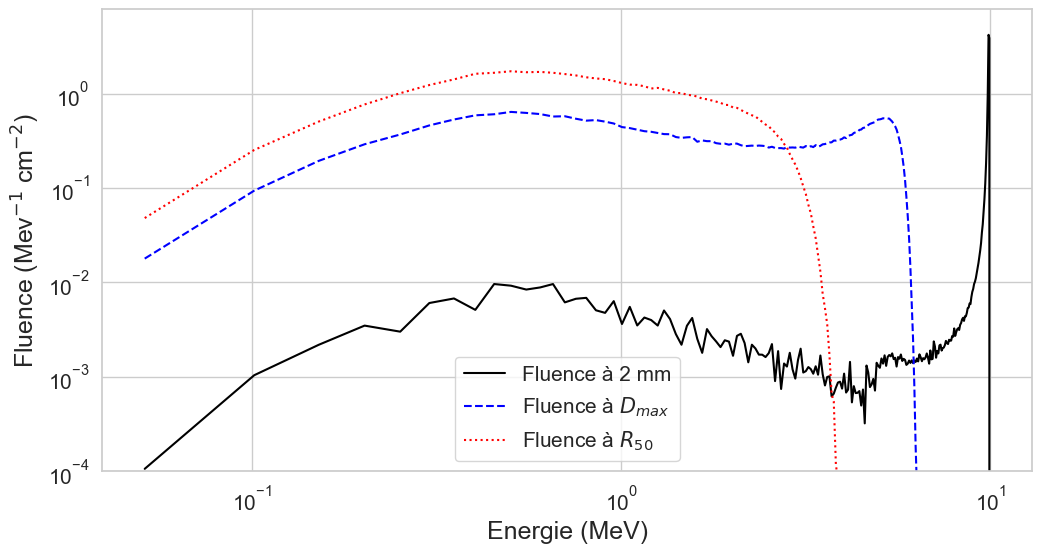

In [16]:

Primary_fluence_entrance = data1[Entrance,:200]/Energy/100
Primary_fluence_Dmax = data1[Dmax,:200]/Energy/100
Primary_fluence_R50 = data1[R50,:200]/Energy/100

fig = plt.figure(figsize=(12,6))

plt.plot(Energy[1:], Primary_fluence_entrance[1:],c="black",label = "Fluence à 2 mm")
plt.plot(Energy[1:], Primary_fluence_Dmax[1:], linestyle='--' ,c='blue', label = "Fluence à $D_{max}$")
plt.plot(Energy[1:], Primary_fluence_R50[1:], linestyle='dotted', c='red', label = "Fluence à $R_{50}$")

plt.xlabel(r'Energie (MeV)', fontsize=18)
plt.ylabel(r'Fluence (Mev$^{-1}$ cm$^{-2}$)', fontsize=18)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-4,)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

#plt.savefig("./Isaac/data3/Figures/Fluence_electrons_primaire.jpg",dpi=300,bbox_inches="tight")
plt.show()





### Graphique de la fluence secondaire


Pour les spectres des électrons secondaires, on constate que la plupart d’entre eux ont des énergies plus faibles que les électrons primaires qui se concentraient à 10 MeV.

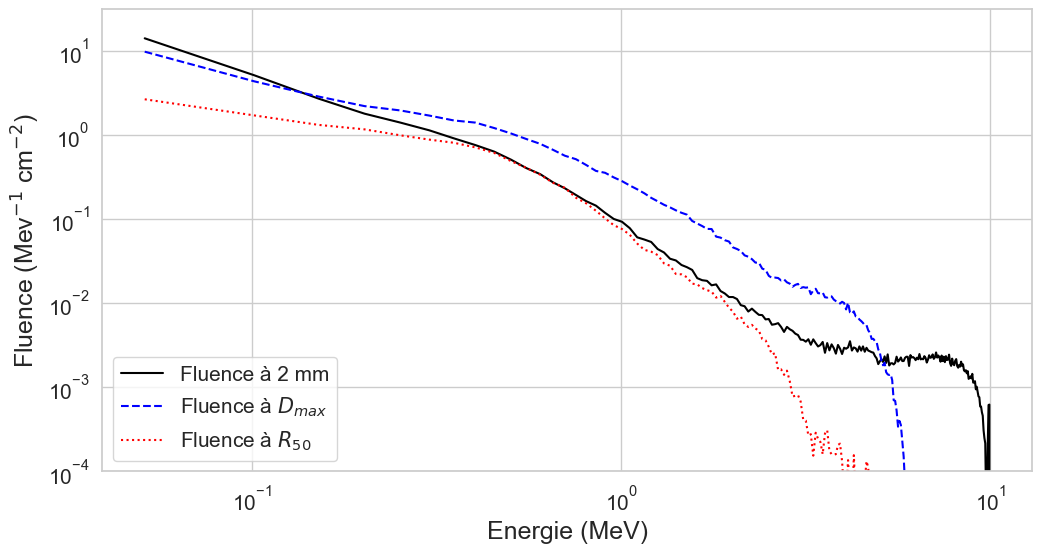

In [17]:
Secondary_fluence_entrance = data2[Entrance,:200]/Energy/100
Secondary_fluence_Dmax = data2[Dmax,:200]/Energy/100
Secondary_fluence_R50 = data2[R50,:200]/Energy/100

fig = plt.figure(figsize=(12,6))

plt.plot(Energy[1:], Secondary_fluence_entrance[1:],c="black",label = "Fluence à 2 mm")
plt.plot(Energy[1:], Secondary_fluence_Dmax[1:], linestyle='--' ,c='blue', label = "Fluence à $D_{max}$")
plt.plot(Energy[1:], Secondary_fluence_R50[1:], linestyle='dotted', c='red', label = "Fluence à $R_{50}$")

plt.xlabel(r'Energie (MeV)', fontsize=18)
plt.ylabel(r'Fluence (Mev$^{-1}$ cm$^{-2}$)', fontsize=18)

plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-4,)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15,loc="lower left")

#plt.savefig("./Isaac/data3/Figures/Fluence_electrons_secondaire.jpg",dpi=300,bbox_inches="tight")
plt.show()





### Graphique de la fluence totale


En additionnant les spectres d’électrons primaires et secondaires, on peut voir que la fluence des électrons secondaires domine à basse énergie, tandis que la fluence des électrons primaires domine à hautes énergies.

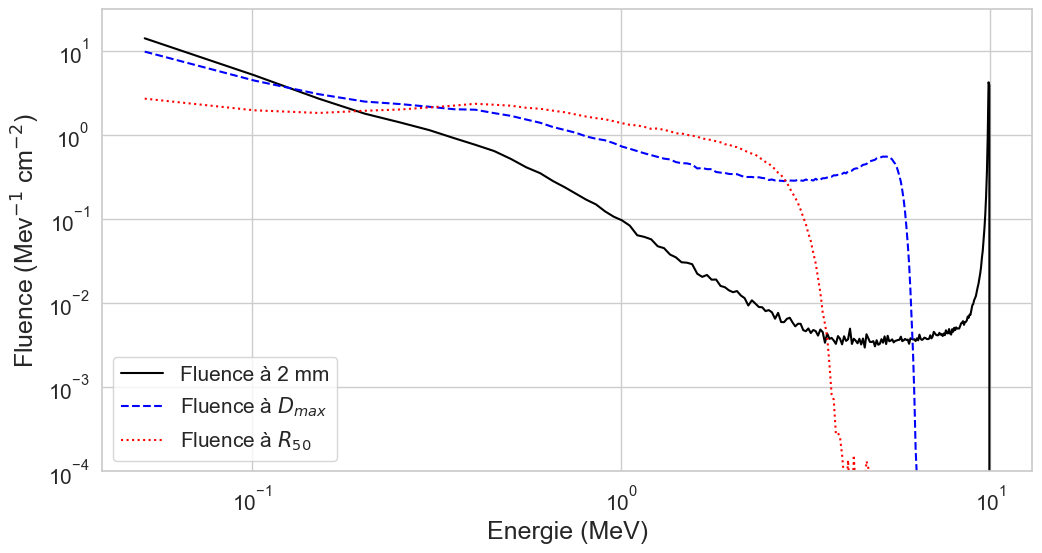

In [18]:
#Total electron fluence
Total_fluence_entrance = Primary_fluence_entrance+Secondary_fluence_entrance
Total_fluence_Dmax = Primary_fluence_Dmax+Secondary_fluence_Dmax
Total_fluence_R50 = Primary_fluence_R50+Secondary_fluence_R50

fig = plt.figure(figsize=(12,6))

plt.plot(Energy[1:], Total_fluence_entrance[1:],c="black",label = "Fluence à 2 mm")
plt.plot(Energy[1:], Total_fluence_Dmax[1:], linestyle='--' ,c='blue', label = "Fluence à $D_{max}$")
plt.plot(Energy[1:], Total_fluence_R50[1:], linestyle='dotted', c='red', label = "Fluence à $R_{50}$")

plt.xlabel(r'Energie (MeV)', fontsize=18)
plt.ylabel(r'Fluence (Mev$^{-1}$ cm$^{-2}$)', fontsize=18)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-4,)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15,loc="lower left")

#plt.savefig("./Isaac/data3/Figures/Electron_fluence_totale.jpg",dpi=300,bbox_inches="tight")

plt.show()


